In [1]:
# get h5 file 'posterior_samples.h5'
import numpy as np
import h5py
import matplotlib.pyplot as plt
import corner

# read h5 file
f = h5py.File('posterior_samples.h5', 'r')

## Let's look at the PE distribution

In [2]:
events = f['Combined_PHM_lowSecondarySpin']['posterior_samples']

In [3]:
events['mass_1']

array([3.70417459, 3.98279781, 4.01425008, ..., 3.86394979, 3.66827051,
       3.67850221])

In [4]:
m10 = np.array(events['mass_1_source'])
m20 = np.array(events['mass_2_source'])
chirp_mass0 = ( (m10*m20)**(3/5) )/( (m10+m20)**(1/5) )
D0 = np.array(events['luminosity_distance'])
theta_jn0 = np.arccos(np.array(events['theta_jn']))
mass_ratio0 = m20/m10

# find nan in theta_jn
idx = np.isnan(theta_jn0)
m10 = m10[~idx]
m20 = m20[~idx]
chirp_mass0 = chirp_mass0[~idx]
D0 = D0[~idx]
theta_jn0 = theta_jn0[~idx]
mass_ratio0 = mass_ratio0[~idx]

/var/folders/ws/0948zvwd7g795j2l3fryghjw0000gp/T/ipykernel_40210/1075654191.py:5: RuntimeWarning: invalid value encountered in arccos
  theta_jn0 = np.arccos(np.array(events['theta_jn']))


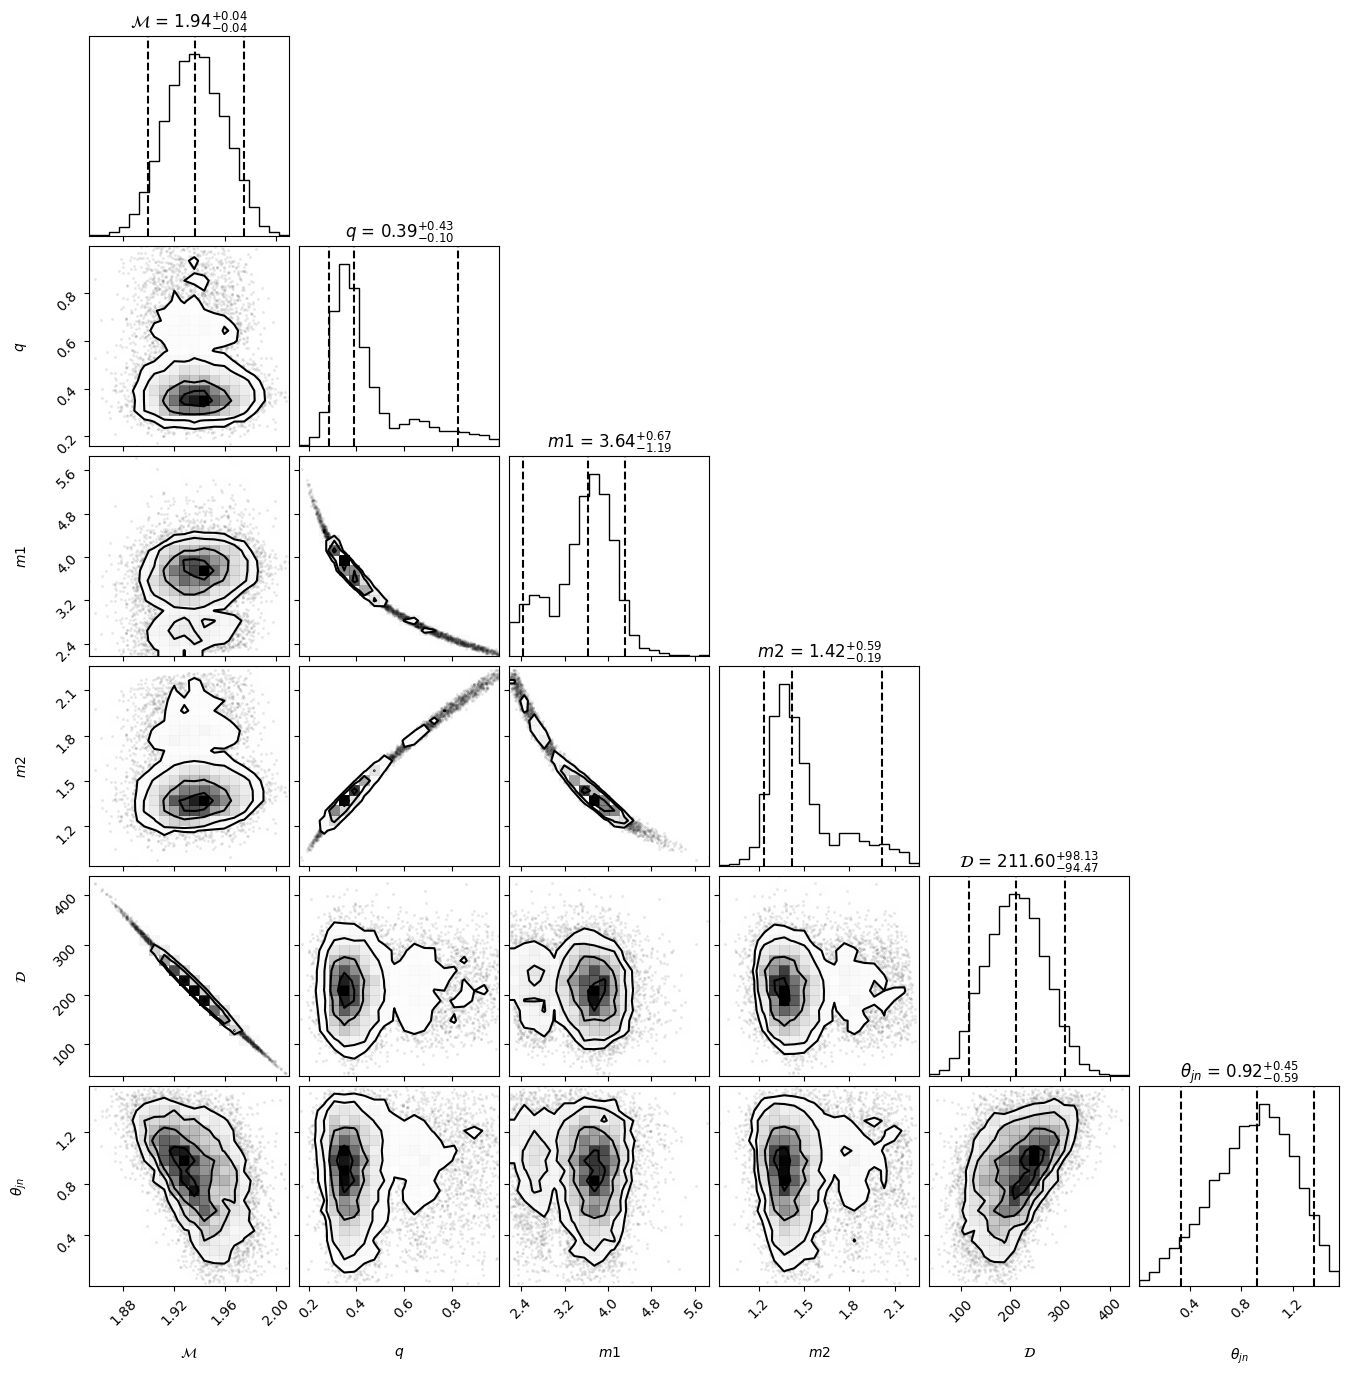

In [5]:
data0 = np.transpose(np.array([chirp_mass0,mass_ratio0,m10,m20,D0,theta_jn0]))
figure = corner.corner(data0, labels=[r"$\mathcal{M}$", r"$q$",r"$m1$", r"$m2$", r"$\mathcal{D}$", r"$\theta_{jn}$"],
                       quantiles=[0.05, 0.5, 0.95],
                       show_titles=True, title_kwargs={"fontsize": 12})

* there is so much error in mass-ratio
* what are the corresponding parameter values at the q_min and q_max?

In [6]:
# consider only 90% of the samples wrt mass ratio
min_mass_ratio = np.percentile(mass_ratio0, 5)
max_mass_ratio = np.percentile(mass_ratio0, 95)
idx_mass_ratio = (mass_ratio0 > min_mass_ratio) & (mass_ratio0 < max_mass_ratio)

mc = chirp_mass0[idx_mass_ratio]
q = mass_ratio0[idx_mass_ratio]
m1 = m10[idx_mass_ratio]
m2 = m20[idx_mass_ratio]
dl = D0[idx_mass_ratio]

idx = np.where(q == np.max(q))
print('max q:',q[idx])
print('max mc:',mc[idx])
print('max m1:',m1[idx])
print('max m2:',m2[idx])
print('max dl:',dl[idx])

idx = np.where(q == np.min(q))
print('\n')
print('min q:',q[idx])
print('min mc:',mc[idx])
print('min m1:',m1[idx])
print('min m2:',m2[idx])
print('min dl:',dl[idx])


max q: [0.82464959]
max mc: [1.95262923]
max m1: [2.47225926]
max m2: [2.0387476]
max dl: [168.58691775]


min q: [0.28730986]
min mc: [1.91272188]
min m1: [4.25185189]
min m2: [1.22159897]
min dl: [279.60435481]


## Finding resonable redshift by considering that it is a lensed event 

In [7]:
# convert redshift to luminosity distance with astropy
from astropy.cosmology import Planck18
from astropy import units as u
from ler.rates import LeR
from scipy.interpolate import interp1d

ler = LeR(verbose=False)

z_to_dl = lambda z: Planck18.luminosity_distance(z).to(u.Mpc).value

z = np.linspace(0, 10, 1000)
luminosity_distance = Planck18.luminosity_distance(z).value
from scipy.interpolate import interp1d
dl_to_z = interp1d(luminosity_distance, z, kind='cubic', fill_value='extrapolate')

In [8]:
# from https://gwosc.org/eventapi/html/O4_Discovery_Papers/GW230529_181500/v1/ 
mass_1_source = 3.6
mass_2_source = 1.4
effective_luminosity_distance = 201
zs_eff = ler.Dl_to_z(np.array([effective_luminosity_distance]))
print('zs_eff:',zs_eff)

# detector frame masses
mass_1 = mass_1_source*(1+zs_eff)
mass_2 = mass_2_source*(1+zs_eff)
print('mass_1:',mass_1)
print('mass_2:',mass_2)

zs_eff: [0.04536316]
mass_1: [3.76330736]
mass_2: [1.46350842]


### Single value assumption

In [9]:
# Assumption for lensing case
zs = 0.46
luminosity_distance = z_to_dl(zs)
print('luminosity_distance:',luminosity_distance)

luminosity_distance: 2643.166349739511


* Calculate possible magnification

$$ \mu = \left(\frac{D_l}{D_l^{eff}}\right)^2 $$

In [10]:
mu = (luminosity_distance/effective_luminosity_distance)**2
print('magnification:',mu)

magnification: 172.92463930089085


In [11]:
# source frame masses, for the lensed event, with zs=0.46
mass_1_source_lensed = mass_1/(1+zs)
mass_2_source_lensed = mass_2/(1+zs)
print('source frame mass_1:', mass_1_source_lensed)
print('source frame mass_2:', mass_2_source_lensed)
mc_source_lensed = ( (mass_1_source_lensed*mass_2_source_lensed)**(3/5) )/( (mass_1_source_lensed+mass_2_source_lensed)**(1/5) )
print('source frame chirp mass:', mc_source_lensed)

source frame mass_1: [2.57760778]
source frame mass_2: [1.00240303]
source frame chirp mass: [1.3695524]


### distributed value assumption

* posterior overlap would be a good option, but we don't have the KDE for the simulated lensed events

In [85]:
# get the unlensed event
from ler.utils import get_param_from_json
unlensed_params = get_param_from_json('ler_data/n_unlensed_detectable_bns.json')

In [116]:
m1_unlensed = unlensed_params['mass_1_source']
m2_unlensed = unlensed_params['mass_2_source']
mc_unlensed = ( (m1_unlensed*m2_unlensed)**(3/5) )/( (m1_unlensed+m2_unlensed)**(1/5) )
zs_unlensed = unlensed_params['zs']

In [100]:
# get the lensed event
from ler.utils import get_param_from_json
lensed_params = get_param_from_json('ler_data/n_lensed_detectable_bns.json')

* To find parameters for the detectable lensed event

In [101]:
# detectable
lensed_params_detectable = get_param_from_json('ler_data/n_lensed_detectable_bns.json')

# detector frame masses
m1_l_det = np.array(lensed_params_detectable['mass_1'])
m2_l_det = np.array(lensed_params_detectable['mass_2'])
# chirp mass
mc_l_det = m1_l_det
mc_l_det = np.array([mc_l_det, mc_l_det, mc_l_det, mc_l_det]).T
m1_l_det = np.array([m1_l_det, m1_l_det, m1_l_det, m1_l_det]).T
m2_l_det = np.array([m2_l_det, m2_l_det, m2_l_det, m2_l_det]).T

# redshifts
zs_l_det = np.array(lensed_params_detectable['zs'])
zs_l_det = np.array([zs_l_det, zs_l_det, zs_l_det, zs_l_det]).T

# observed
dl_l_eff_det = np.array(lensed_params_detectable['effective_luminosity_distance'])
zs_l_eff_det = dl_to_z(np.array(dl_l_eff_det))
mc_l_eff_det = mc_l_det/(1+zs_l_eff_det)
m1_l_eff_det = m1_l_det/(1+zs_l_eff_det)
m2_l_eff_det = m2_l_det/(1+zs_l_eff_det)

# avoid nan
zs_l_eff_det = zs_l_eff_det.flatten()
mc_l_eff_det = mc_l_eff_det.flatten()
m1_l_eff_det = m1_l_eff_det.flatten()
m2_l_eff_det = m2_l_eff_det.flatten()
zs_l_det = zs_l_det.flatten()
idx_nan = np.isnan(zs_l_eff_det)
zs_l_eff_det = zs_l_eff_det[~idx_nan]
mc_l_eff_det = mc_l_eff_det[~idx_nan]
m1_l_eff_det = m1_l_eff_det[~idx_nan]
m2_l_eff_det = m2_l_eff_det[~idx_nan]
zs_l_det = zs_l_det[~idx_nan]

# choose only detectable
snr_l_det = np.array(lensed_params_detectable['optimal_snr_net']).flatten()
snr_l_det = snr_l_det[~idx_nan]
idx_detectable = snr_l_det > 8
zs_l_eff_det = zs_l_eff_det[idx_detectable]
mc_l_eff_det = mc_l_eff_det[idx_detectable]
m1_l_eff_det = m1_l_eff_det[idx_detectable]
m2_l_eff_det = m2_l_eff_det[idx_detectable]
zs_l_det = zs_l_det[idx_detectable]

### Contour plots

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [111]:
# unlensed 
events = f['Combined_PHM_lowSecondarySpin']['posterior_samples']
#events['mass_1']
# detector farme
m1 = np.array(events['mass_1_source'])
m2 = np.array(events['mass_2_source'])
unlensed_mass_1 = m1[:945]
unlensed_mass_2 = m2[:945]
unlensed_chirp_mass = ( (m1*m2)**(3/5) )/( (m1+m2)**(1/5) )
unlensed_chirp_mass = unlensed_chirp_mass[:945]
dl = np.array(events['luminosity_distance'])
unlensed_redshift = dl_to_z(dl)[:945]

In [75]:
print(len(unlensed_chirp_mass)) 
print(len(unlensed_redshift))

945
945


In [76]:
# lensed
lensed_chirp_mass = mc_l_eff_det
lensed_redshift = zs_l_eff_det


In [77]:
print(len(lensed_chirp_mass))
print(len(lensed_redshift))

945
945


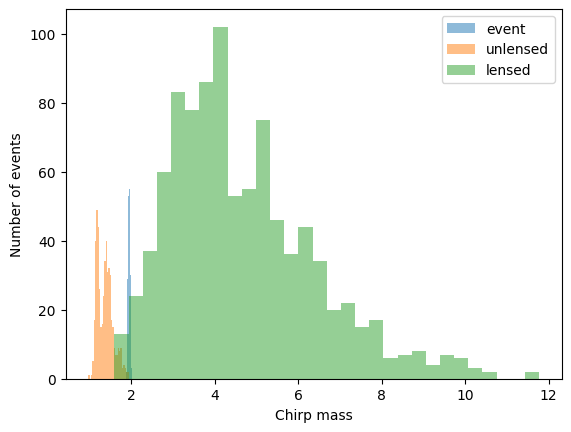

In [117]:
plt.hist(unlensed_chirp_mass, bins=30, alpha=0.5, density=False, label='event')
plt.hist(mc_unlensed[:945], bins=30, alpha=0.5, density=False, label='unlensed')
plt.hist(mc_l_eff_det, bins=30, alpha=0.5, density=False, label='lensed')
plt.xlabel('inferred Chirp mass')
plt.ylabel('Number of events')
plt.legend()
plt.show()

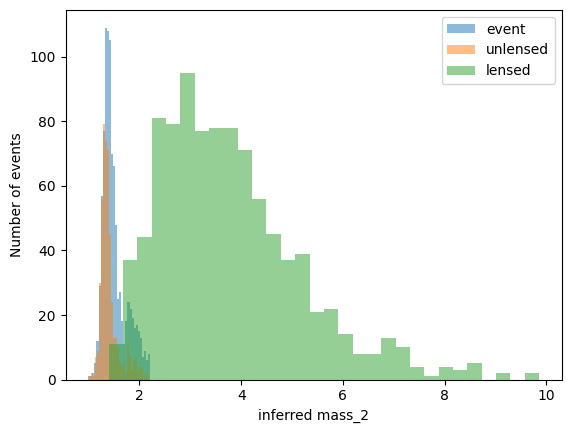

In [118]:
plt.hist(unlensed_mass_2, bins=30, alpha=0.5, density=False, label='event')
plt.hist(m2_unlensed[:945], bins=30, alpha=0.5, density=False, label='unlensed')
plt.hist(m2_l_eff_det, bins=30, alpha=0.5, density=False, label='lensed')
plt.xlabel('inferred mass_2')
plt.ylabel('Number of events')
plt.legend()
plt.show()

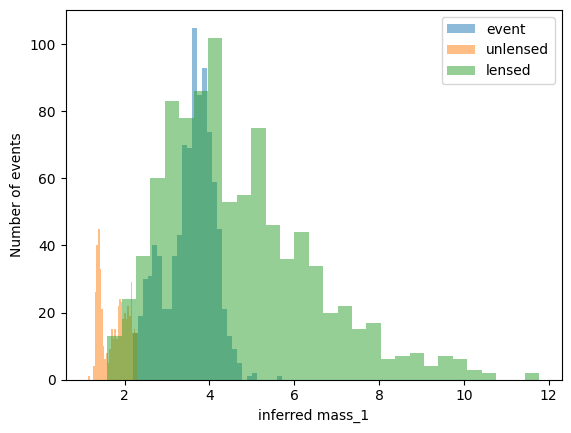

In [119]:
plt.hist(unlensed_mass_1, bins=30, alpha=0.5, density=False, label='event')
plt.hist(m1_unlensed[:945], bins=30, alpha=0.5, density=False, label='unlensed')
plt.hist(m1_l_eff_det, bins=30, alpha=0.5, density=False, label='lensed')
plt.xlabel('inferred mass_1')
plt.ylabel('Number of events')
plt.legend()
plt.show()

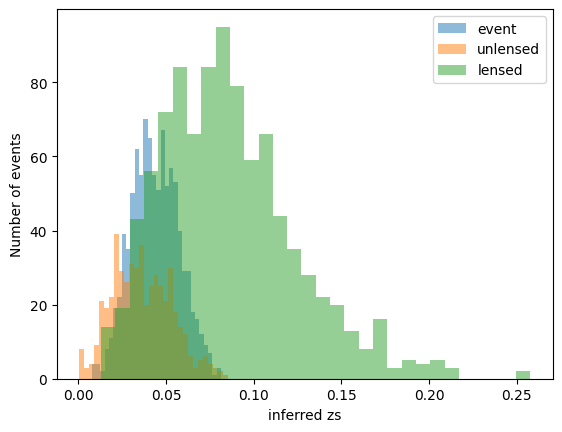

In [120]:
plt.hist(unlensed_redshift, bins=30, alpha=0.5, density=False, label='event')
plt.hist(zs_unlensed, bins=30, alpha=0.5, density=False, label='unlensed')
plt.hist(zs_l_eff_det, bins=30, alpha=0.5, density=False, label='lensed')
plt.xlabel('inferred zs')
plt.ylabel('Number of events')
plt.legend()
plt.show()

In [108]:
# unlened
# Assuming your data is loaded and you have mass, redshift arrays
# Replace these with your actual data arrays
# mass = unlensed_mass_1  # Your mass data
# redshift = unlensed_redshift  # Your redshift data
mass = m1_unlensed[:945]  # Your mass data
redshift = zs_unlensed[:945]  # Your redshift data

# Perform a kernel density estimation (KDE)
xy = np.vstack([redshift, mass])
kde = gaussian_kde(xy)(xy)

# Define the levels for contour as percentiles of the density
levels1 = np.percentile(kde, [5, 32, 60, 90])

# Create a grid for contour plot
xgrid = np.linspace(min(redshift), max(redshift), 1000)
ygrid = np.linspace(min(mass), max(mass), 1000)
X1, Y1 = np.meshgrid(xgrid, ygrid)
Z1 = gaussian_kde(xy)(np.vstack([X1.ravel(), Y1.ravel()])).reshape(X1.shape)

#lensed
# Assuming your data is loaded and you have mass, redshift arrays
# Replace these with your actual data arrays
mass = m1_l_eff_det  # Your mass data
redshift = lensed_redshift  # Your redshift data

# Perform a kernel density estimation (KDE)
xy = np.vstack([redshift, mass])
kde = gaussian_kde(xy)(xy)

# Define the levels for contour as percentiles of the density
levels2 = np.percentile(kde, [5, 32, 60, 90])

# Create a grid for contour plot
xgrid = np.linspace(min(redshift), max(redshift), 1000)
ygrid = np.linspace(min(mass), max(mass), 1000)
X2, Y2 = np.meshgrid(xgrid, ygrid)
Z2 = gaussian_kde(xy)(np.vstack([X2.ravel(), Y2.ravel()])).reshape(X2.shape)

# event
mass = unlensed_mass_1
redshift = unlensed_redshift

# Perform a kernel density estimation (KDE)
xy = np.vstack([redshift, mass])
kde = gaussian_kde(xy)(xy)

# Define the levels for contour as percentiles of the density
levels3 = np.percentile(kde, [5, 32, 60, 90])

# Create a grid for contour plot
xgrid = np.linspace(min(redshift), max(redshift), 1000)
ygrid = np.linspace(min(mass), max(mass), 1000)
X3, Y3 = np.meshgrid(xgrid, ygrid)
Z3 = gaussian_kde(xy)(np.vstack([X3.ravel(), Y3.ravel()])).reshape(X3.shape)

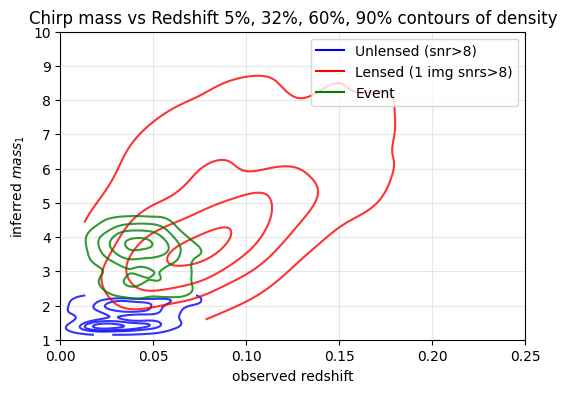

In [110]:
# Plotting
plt.figure(figsize=(6, 4))
plt.contour(X1, Y1, Z1, levels=levels1, colors=['blue', 'blue', 'blue', 'blue', 'blue'], alpha=0.8)
plt.contour(X2, Y2, Z2, levels=levels2, colors=['red', 'red', 'red', 'red', 'red'], alpha=0.8)
plt.contour(X3, Y3, Z3, levels=levels3, colors=['green', 'green', 'green', 'green', 'green'], alpha=0.8)

plt.xlabel("observed redshift")
plt.ylabel(r"inferred $mass_1$")
plt.title("Chirp mass vs Redshift 5%, 32%, 60%, 90% contours of density")
# plt.colorbar(contour1, label='Density')
plt.xlim(0, 0.25)
plt.ylim(1, 10)
plt.grid(alpha=0.3)
# Add legend
# Create proxy artists for legend
proxy1 = plt.Line2D([0], [0], linestyle='-', color='blue', label='Unlensed (snr>8)')
proxy2 = plt.Line2D([0], [0], linestyle='-', color='red', label='Lensed (1 img snrs>8)')
proxy3 = plt.Line2D([0], [0], linestyle='-', color='green', label='Event')
plt.legend(handles=[proxy1, proxy2, proxy3])
plt.show()

In [112]:
# unlened
# Assuming your data is loaded and you have mass, redshift arrays
# Replace these with your actual data arrays
# mass = unlensed_mass_1  # Your mass data
# redshift = unlensed_redshift  # Your redshift data
mass = m2_unlensed[:945]  # Your mass data
redshift = zs_unlensed[:945]  # Your redshift data

# Perform a kernel density estimation (KDE)
xy = np.vstack([redshift, mass])
kde = gaussian_kde(xy)(xy)

# Define the levels for contour as percentiles of the density
levels1 = np.percentile(kde, [5, 32, 60, 90])

# Create a grid for contour plot
xgrid = np.linspace(min(redshift), max(redshift), 1000)
ygrid = np.linspace(min(mass), max(mass), 1000)
X1, Y1 = np.meshgrid(xgrid, ygrid)
Z1 = gaussian_kde(xy)(np.vstack([X1.ravel(), Y1.ravel()])).reshape(X1.shape)

#lensed
# Assuming your data is loaded and you have mass, redshift arrays
# Replace these with your actual data arrays
mass = m2_l_eff_det  # Your mass data
redshift = lensed_redshift  # Your redshift data

# Perform a kernel density estimation (KDE)
xy = np.vstack([redshift, mass])
kde = gaussian_kde(xy)(xy)

# Define the levels for contour as percentiles of the density
levels2 = np.percentile(kde, [5, 32, 60, 90])

# Create a grid for contour plot
xgrid = np.linspace(min(redshift), max(redshift), 1000)
ygrid = np.linspace(min(mass), max(mass), 1000)
X2, Y2 = np.meshgrid(xgrid, ygrid)
Z2 = gaussian_kde(xy)(np.vstack([X2.ravel(), Y2.ravel()])).reshape(X2.shape)

# event
mass = unlensed_mass_2
redshift = unlensed_redshift

# Perform a kernel density estimation (KDE)
xy = np.vstack([redshift, mass])
kde = gaussian_kde(xy)(xy)

# Define the levels for contour as percentiles of the density
levels3 = np.percentile(kde, [5, 32, 60, 90])

# Create a grid for contour plot
xgrid = np.linspace(min(redshift), max(redshift), 1000)
ygrid = np.linspace(min(mass), max(mass), 1000)
X3, Y3 = np.meshgrid(xgrid, ygrid)
Z3 = gaussian_kde(xy)(np.vstack([X3.ravel(), Y3.ravel()])).reshape(X3.shape)

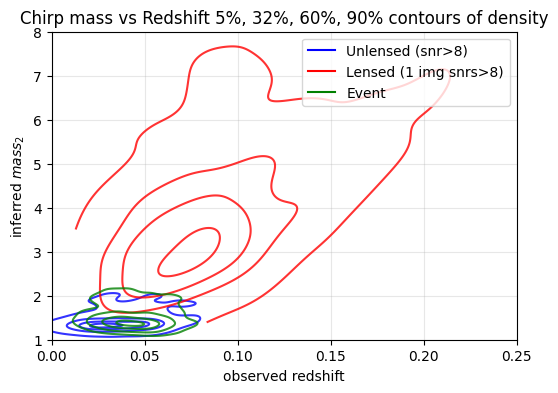

In [114]:
# Plotting
plt.figure(figsize=(6, 4))
plt.contour(X1, Y1, Z1, levels=levels1, colors=['blue', 'blue', 'blue', 'blue', 'blue'], alpha=0.8)
plt.contour(X2, Y2, Z2, levels=levels2, colors=['red', 'red', 'red', 'red', 'red'], alpha=0.8)
plt.contour(X3, Y3, Z3, levels=levels3, colors=['green', 'green', 'green', 'green', 'green'], alpha=0.8)

plt.xlabel("observed redshift")
plt.ylabel(r"inferred $mass_2$")
plt.title("Chirp mass vs Redshift 5%, 32%, 60%, 90% contours of density")
# plt.colorbar(contour1, label='Density')
plt.xlim(0, 0.25)
plt.ylim(1, 8)
plt.grid(alpha=0.3)
# Add legend
# Create proxy artists for legend
proxy1 = plt.Line2D([0], [0], linestyle='-', color='blue', label='Unlensed (snr>8)')
proxy2 = plt.Line2D([0], [0], linestyle='-', color='red', label='Lensed (1 img snrs>8)')
proxy3 = plt.Line2D([0], [0], linestyle='-', color='green', label='Event')
plt.legend(handles=[proxy1, proxy2, proxy3])
plt.show()

In [124]:
# unlened
# Assuming your data is loaded and you have mass, redshift arrays
# Replace these with your actual data arrays
# mass = unlensed_mass_1  # Your mass data
# redshift = unlensed_redshift  # Your redshift data
mass = mc_unlensed[:945]  # Your mass data
redshift = zs_unlensed[:945]  # Your redshift data

# Perform a kernel density estimation (KDE)
xy = np.vstack([redshift, mass])
kde = gaussian_kde(xy)(xy)

# Define the levels for contour as percentiles of the density
levels1 = np.percentile(kde, [5, 32, 60, 90])

# Create a grid for contour plot
xgrid = np.linspace(min(redshift), max(redshift), 1000)
ygrid = np.linspace(min(mass), max(mass), 1000)
X1, Y1 = np.meshgrid(xgrid, ygrid)
Z1 = gaussian_kde(xy)(np.vstack([X1.ravel(), Y1.ravel()])).reshape(X1.shape)

#lensed
# Assuming your data is loaded and you have mass, redshift arrays
# Replace these with your actual data arrays
mass = mc_l_eff_det  # Your mass data
redshift = lensed_redshift  # Your redshift data

# Perform a kernel density estimation (KDE)
xy = np.vstack([redshift, mass])
kde = gaussian_kde(xy)(xy)

# Define the levels for contour as percentiles of the density
levels2 = np.percentile(kde, [5, 32, 60, 90])

# Create a grid for contour plot
xgrid = np.linspace(min(redshift), max(redshift), 1000)
ygrid = np.linspace(min(mass), max(mass), 1000)
X2, Y2 = np.meshgrid(xgrid, ygrid)
Z2 = gaussian_kde(xy)(np.vstack([X2.ravel(), Y2.ravel()])).reshape(X2.shape)

# event
mass = unlensed_chirp_mass[:945]
redshift = unlensed_redshift[:945]

# Perform a kernel density estimation (KDE)
xy = np.vstack([redshift, mass])
kde = gaussian_kde(xy)(xy)

# Define the levels for contour as percentiles of the density
levels3 = np.percentile(kde, [5, 32, 60, 90])

# Create a grid for contour plot
xgrid = np.linspace(min(redshift), max(redshift), 1000)
ygrid = np.linspace(min(mass), max(mass), 1000)
X3, Y3 = np.meshgrid(xgrid, ygrid)
Z3 = gaussian_kde(xy)(np.vstack([X3.ravel(), Y3.ravel()])).reshape(X3.shape)

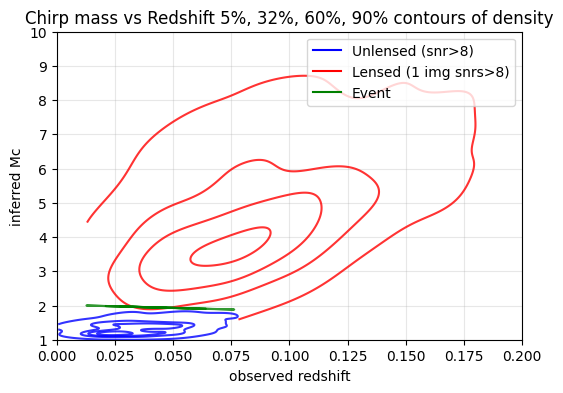

In [126]:
# Plotting
plt.figure(figsize=(6, 4))
plt.contour(X1, Y1, Z1, levels=levels1, colors=['blue', 'blue', 'blue', 'blue', 'blue'], alpha=0.8)
plt.contour(X2, Y2, Z2, levels=levels2, colors=['red', 'red', 'red', 'red', 'red'], alpha=0.8)
plt.contour(X3, Y3, Z3, levels=levels3, colors=['green', 'green', 'green', 'green', 'green'], alpha=0.8)

plt.xlabel("observed redshift")
plt.ylabel(r"inferred Mc")
plt.title("Chirp mass vs Redshift 5%, 32%, 60%, 90% contours of density")
# plt.colorbar(contour1, label='Density')
plt.xlim(0, 0.2)
plt.ylim(1, 10)
plt.grid(alpha=0.3)
# Add legend
# Create proxy artists for legend
proxy1 = plt.Line2D([0], [0], linestyle='-', color='blue', label='Unlensed (snr>8)')
proxy2 = plt.Line2D([0], [0], linestyle='-', color='red', label='Lensed (1 img snrs>8)')
proxy3 = plt.Line2D([0], [0], linestyle='-', color='green', label='Event')
plt.legend(handles=[proxy1, proxy2, proxy3])
plt.show()